In [18]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_theme()

Given:

- $n = 200$
- $\alpha = 0.05$, false positive rate if $H_0$ is true
- $(1 - \alpha) = 0.95$, true negative rate if $H_0$ is true.
- $\beta = 0.20$, false negative rate if $H_A$ is true
- $(1 - \beta) = 0.80$, true positive rate if $H_A$ is true.
- $50\%$ probability that $H_0$ is true (this is the same as $50\%$ probabilty that $H_0$ is false and $H_A$ is true/false)

|                       | $H_0$ TRUE                                                     | $H_A$ TRUE                                                  |
|-----------------------|----------------------------------------------------------------|-------------------------------------------------------------|
| Significant finding   | $$50\% \times \alpha \: (FP) \times n = 5 \: (2.5\%)$$         | $$50\% \times (1 - \beta) \: (TP) \times n = 80 \: (40\%)$$ |
| Insignificant finding | $$50\% \times (1 - \alpha) \: (TN) \times n = 95 \: (47.5\%)$$ | $$50\% \times \beta \: (FN) \times n = 20 \: (10\%) $$      |

**Positive predictive value (PPV)**:
- True postives we can expect among all positive results.

$$ PPV = precision = \frac {True\:positives} {True\:positives + False\:positives} $$

**False positive report probability (FPRP)**:
- False positive we can expect among all positive results.

$$ FPRP = FPR = \frac {False\:positives} {True\:positives + False\:positives} $$

The lowest p-value was observed at sample size  11
The p-value dropped below 0.05 for the first time at sample size: 11


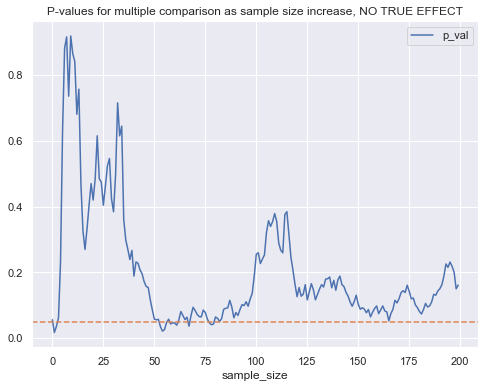

In [43]:
n_datapoints = 200
d_effect_size = 0.0

p_vals, x_vals, y_vals = [], [], []

n_datapoints += 10

for idx in range(n_datapoints):
    x_vals.append(np.random.normal())
    y_vals.append(np.random.normal(loc=d_effect_size))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            p_vals.append(st.ttest_ind(x_vals[:idx], y_vals[:idx])[1])
        except TypeError:
            p_vals.append(np.nan)

p_vals = p_vals[10:]
                  
fig, ax = plt.subplots(figsize=(8, 6))
pd.Series(p_vals, name="p_val").reset_index().rename({"index": "sample_size"}, axis=1).plot(x="sample_size", y="p_val", ax=ax)
ax.axhline(0.05, linestyle="--", color="C1")
print("The lowest p-value was observed at sample size ", p_vals.index(min(p_vals)) + 10)
sig = [p_val for p_val in p_vals if p_val < 0.05]
print("The p-value dropped below 0.05 for the first time at sample size:", p_vals.index(sig[0]) + 10 if sig else "NEVER")
ax.set_title("P-values for multiple comparison as sample size increase, NO TRUE EFFECT");

The lowest p-value was observed at sample size  209
The p-value dropped below 0.05 for the first time at sample size: 52


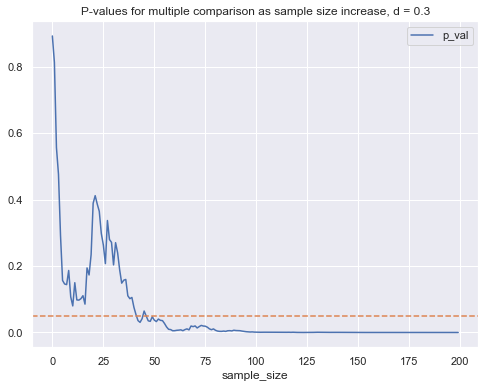

In [45]:
n_datapoints = 200
d_effect_size = 0.3

p_vals, x_vals, y_vals = [], [], []

n_datapoints += 10

for idx in range(n_datapoints):
    x_vals.append(np.random.normal())
    y_vals.append(np.random.normal(loc=d_effect_size))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            p_vals.append(st.ttest_ind(x_vals[:idx], y_vals[:idx])[1])
        except TypeError:
            p_vals.append(np.nan)

p_vals = p_vals[10:]
                  
fig, ax = plt.subplots(figsize=(8, 6))
pd.Series(p_vals, name="p_val").reset_index().rename({"index": "sample_size"}, axis=1).plot(x="sample_size", y="p_val", ax=ax)
ax.axhline(0.05, linestyle="--", color="C1")
print("The lowest p-value was observed at sample size ", p_vals.index(min(p_vals)) + 10)
sig = [p_val for p_val in p_vals if p_val < 0.05]
print("The p-value dropped below 0.05 for the first time at sample size:", p_vals.index(sig[0]) + 10 if sig else "NEVER")
ax.set_title("P-values for multiple comparison as sample size increase, d = 0.3");

In [64]:
np.ceil(np.arange(100 / 5, 101, (100 - 100 / 5) / (5 - 1)))

array([ 20.,  40.,  60.,  80., 100.])

Type 1 error rates for look 1 to 5: [0.05006 0.05004 0.05006 0.05012 0.04968]
Type 1 error rate when only the lowest p-value for all looks is reported: 0.14186


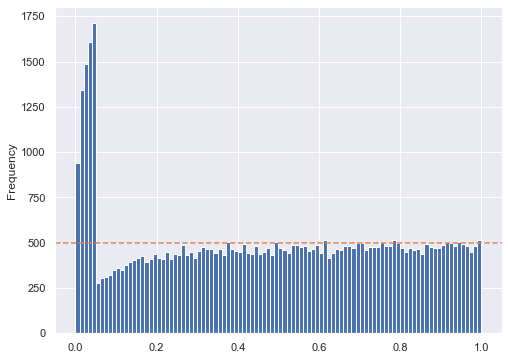

In [132]:
n_datapoints = 100
looks = 5
n_simulations = 50_000
alpha = 0.05

if looks > 0:
    look_at_n = np.ceil(np.arange(n_datapoints / looks, n_datapoints + 1, (n_datapoints - n_datapoints / looks) / (looks - 1)))

else:
    look_at_n = [n_datapoints]
    
look_at_n = [int(look) for look in look_at_n if look > 2]
looks = len(look_at_n)

p_vals = []
for idx_i in range(n_simulations):
    x = np.random.normal(size=n_datapoints)
    y = np.random.normal(size=n_datapoints)
    
    row = []
    for idx_j in range(looks):
        row.append(st.ttest_ind(x[:look_at_n[idx_j]], y[:look_at_n[idx_j]])[1])
    
    p_vals.append(row)
    print(f"Loop {idx_i} of {n_simulations}", end="\r")

p_vals = np.array(p_vals)
p_vals_filtered = []

for idx in range(n_simulations):
    if len(p_vals[idx, p_vals[idx] < alpha]) == 0:
        p_vals_filtered.append(p_vals[idx, looks - 1])
    else:
        p_vals_filtered.append(p_vals[idx, p_vals[idx] < alpha][0])
        
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(p_vals_filtered, name="p-vals").hist(bins=100, ax=ax)
ax.axhline(n_simulations/100, color="C1", linestyle="--")
ax.set_ylabel("Frequency")
print(f"Type 1 error rates for look 1 to {looks}: {(p_vals < alpha).sum(axis=0) / n_simulations}")
print(f"Type 1 error rate when only the lowest p-value for all looks is reported: {(np.array(p_vals_filtered) < alpha).sum() / n_simulations}")

**Q1:** In the example at the start of this chapter, we see that we control the Type 1 error rate at 5% by using an alpha of 0.05. Still, when there is a 50% probability that H0 is true, the proportion of false positives for all experiments performed turns out to be much lower, namely 2.5%, or 0.025. Why?

1. The proportion of false positives for all experiments we have performed is a variable with a distribution around the true error rate – sometimes it’s higher, sometimes it’s lower, due to random variation.
2. **The proportion of false positives for all experiments we have performed is only 5% when H0 is true for all 200 studies.**
3. The proportion of false positives for all experiments we have performed is only 5% when you have 50% power – if power increases above 50%, the proportion of false positives for all experiments we have performed becomes smaller.
4. The proportion of false positives for all experiments we have performed is only 5% when you have 100% power, and it becomes smaller if power is lower than 100%.

**Q2:** What will make the biggest difference in improving the probability that you will find a true positive? Check your answer by shifting the sliders in the online PPV app at http://shinyapps.org/apps/PPV/ or https://shiny.ieis.tue.nl/PPV/

1. Increase the % of a-priori true hypotheses
2. Decrease the % of a-priori true hypotheses
3. Increase the alpha level
4. Decrease the alpha level
5. **Increase the power**
6. Decrease the power

Increasing the power requires bigger sample sizes, or studying larger effects. Increasing the % of a-priori true hypotheses can be done by making better predictions – for example building on reliable findings, and relying on strong theories. These are useful recommendations if you want to increase the probability of performing studies where you find a statistically significant result.

**Q3:** Set the “% of a priori true hypotheses” slider to 50%. Leave the ‘α level’ slider at 5%. Leave the ‘% of p-hacked studies’ slider at 0. The title of Ioannidis’ paper is ‘why most published research findings are false’. One reason might be that studies often have low power. At which value for power is the PPV 50%. In other words, at which level of power is a significant result just as likely to be true, as that it is false?

1. 80%
2. 50%
3. 20%
4. **5%**


**Q4**: In general, when are most published findings false? Interpret ‘low’ and ‘high’ in the answer options below in relation to the values in the first example in this chapter of 50% probability H1 is true, 5% alpha, 80% power, and 0% bias.

1. **When the probability of examining a true hypothesis is low, combined with either low power or substantial bias (e.g., p-hacking).**
2. When the probability of examining a true hypothesis is high, combined with either low power or substantial bias (e.g., p-hacking).
3. When the alpha level is high, combined with either low power or substantial bias (e.g., p-hacking).
4. When power is low and p-hacking is high (regardless of the % of true hypotheses one examines).


**Q5:** Set the “% of a priori true hypotheses” slider to 0%. Set the “% of p-hacked studies” slider to 0%. Set the “α level” slider to 5%. Play around with the power slider. Which statement is true? Without p-hacking, when the alpha level is 5%, and when 0% of the hypotheses are true,

1. the proportion of false positives for all experiments we have performed is 100%.
2. the PPV depends on the power of the studies.
3. regardless of the power, the PPV equals the proportion of false positives for all experiments we have performed.
4. **regardless of the power, the proportion of false positives for all experiments we have performed is 5%, and the PPV is 0% (all significant results are false positives).**


**Q1**: Run the script that plots the p-value as the sample size increases 20 times, and count how often the lowest p-value ends up below 0.05 (we will calculate the long run probability of this happening through more extensive simulations later).

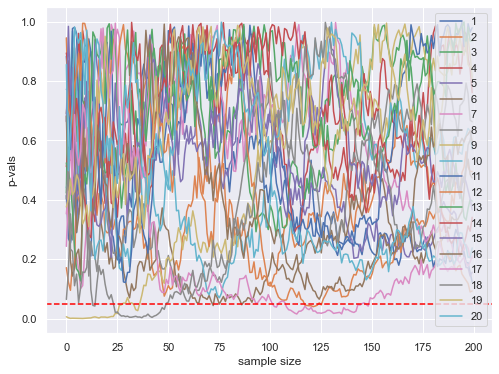

In [145]:
n_datapoints = 200
d_effect_size = 0.0
n_datapoints += 10

trials = {}

for trial in range(20):
    p_vals, x_vals, y_vals = [], [], []
    for idx in range(n_datapoints):
        x_vals.append(np.random.normal())
        y_vals.append(np.random.normal(loc=d_effect_size))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                p_vals.append(st.ttest_ind(x_vals[:idx], y_vals[:idx])[1])
            except TypeError:
                p_vals.append(np.nan)

    p_vals = p_vals[10:]
    trials[trial + 1] = p_vals
                  
fig, ax = plt.subplots(figsize=(8, 6))
pd.DataFrame(trials).plot(ax=ax)
ax.axhline(0.05, linestyle="--", color="red")
# print("The lowest p-value was observed at sample size ", p_vals.index(min(p_vals)) + 10)
# sig = [p_val for p_val in p_vals if p_val < 0.05]
# print("The p-value dropped below 0.05 for the first time at sample size:", p_vals.index(sig[0]) + 10 if sig else "NEVER")
# ax.set_title("P-values for multiple comparison as sample size increase, NO TRUE EFFECT")
ax.set_xlabel("sample size")
ax.set_ylabel("p-vals");

In [146]:
pd.DataFrame(trials)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.414614,0.171353,0.423097,0.511718,0.772441,0.690413,0.243251,0.064206,0.005984,0.441753,0.883785,0.945520,0.524327,0.894394,0.663731,0.682291,0.352590,0.402999,0.375786,0.855791
1,0.269711,0.122997,0.867916,0.576713,0.767431,0.784083,0.434792,0.157672,0.002586,0.460690,0.766936,0.711273,0.493035,0.853297,0.984314,0.410362,0.428732,0.553034,0.405442,0.498053
2,0.253846,0.095133,0.751813,0.533979,0.672964,0.814644,0.596766,0.352381,0.000579,0.815283,0.569577,0.680992,0.457273,0.703802,0.753279,0.194920,0.417217,0.234190,0.469338,0.625906
3,0.294857,0.183433,0.914329,0.581820,0.505155,0.752892,0.445683,0.265072,0.001054,0.968742,0.977031,0.643712,0.365060,0.630142,0.845449,0.143094,0.482682,0.226013,0.416871,0.721707
4,0.425469,0.173712,0.846371,0.911437,0.426631,0.536631,0.228733,0.462150,0.000914,0.914936,0.981233,0.789719,0.238007,0.603536,0.672466,0.168671,0.687179,0.110472,0.429332,0.982123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.224778,0.509255,0.342232,0.967688,0.208292,0.428099,0.230198,0.736453,0.939686,0.602391,0.917482,0.138978,0.999150,0.250790,0.478881,0.594507,0.205278,0.458082,0.887361,0.254152
196,0.188288,0.561932,0.331255,0.959328,0.172024,0.506996,0.249224,0.793375,0.929393,0.615700,0.914439,0.128885,0.898993,0.277688,0.459702,0.613254,0.187209,0.515282,0.931161,0.243844
197,0.187828,0.510301,0.370982,0.875524,0.170786,0.536722,0.236206,0.756892,0.944252,0.640214,0.993079,0.118134,0.981495,0.311933,0.431982,0.621085,0.176632,0.584405,0.855688,0.206838
198,0.154128,0.495682,0.400563,0.840749,0.143230,0.485433,0.203980,0.668038,0.887048,0.631666,0.965094,0.089471,0.934918,0.294278,0.402984,0.632529,0.190410,0.601518,0.846675,0.206274


In [147]:
pd.DataFrame(trials).applymap(lambda cell: cell < 0.05).sum()

1      0
2      0
3      0
4      0
5      0
6      3
7      0
8      0
9     31
10     0
11     0
12     8
13     0
14     0
15     0
16     0
17    43
18    27
19     0
20     0
dtype: int64

Q2: If there is a true effect, we can only observe a true positive or a false negative. Change the effect size from d <- 0.0 to d <- 0.3. This is a relatively small true effect, and with 200 participants in each condition, we have 85% power (or an 85% probability of finding a significant effect). Run the script again. Below is one possible example of the trajectory of p-values as the sample size increases. Run the script 20 times. Take a good look at the variation in the p-value trajectory. Remember that at N = 200, 85% of the times the p-value should have ended up below 0.05. The script returns the sample size the p-value is the lowest (which is often, but not always, at the maximum sample size, when there is a true effect) and the sample size at which the p-value drops below 0.05 for the first time. Which statement is true?

1. If the p-value drops below 0.05, it stays below 0.05.
2. The p-value randomly moves between 0 and 1, and will every now and then end up below 0.05.
3. **The p-value often drops below 0.05 well before 200 participants in each condition. In around 50% of the simulations, this already happens at N = 100.**
4. The p-value will typically move below 0.05 and stay there for some time, but given a large enough sample, it will always move back up to p > 0.05.


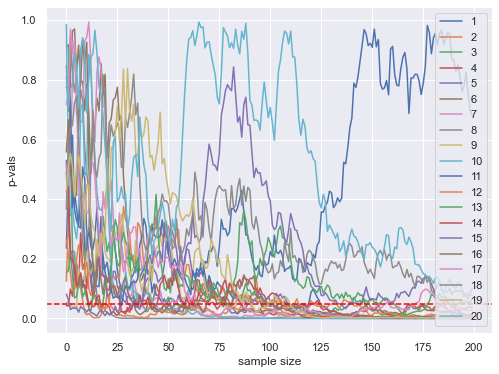

In [148]:
n_datapoints = 200
d_effect_size = 0.3
n_datapoints += 10

trials = {}

for trial in range(20):
    p_vals, x_vals, y_vals = [], [], []
    for idx in range(n_datapoints):
        x_vals.append(np.random.normal())
        y_vals.append(np.random.normal(loc=d_effect_size))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                p_vals.append(st.ttest_ind(x_vals[:idx], y_vals[:idx])[1])
            except TypeError:
                p_vals.append(np.nan)

    p_vals = p_vals[10:]
    trials[trial + 1] = p_vals
                  
fig, ax = plt.subplots(figsize=(8, 6))
pd.DataFrame(trials).plot(ax=ax)
ax.axhline(0.05, linestyle="--", color="red")
# print("The lowest p-value was observed at sample size ", p_vals.index(min(p_vals)) + 10)
# sig = [p_val for p_val in p_vals if p_val < 0.05]
# print("The p-value dropped below 0.05 for the first time at sample size:", p_vals.index(sig[0]) + 10 if sig else "NEVER")
# ax.set_title("P-values for multiple comparison as sample size increase, NO TRUE EFFECT")
ax.set_xlabel("sample size")
ax.set_ylabel("p-vals");

**Q3:** Change the effect size d <- 0.8, which can be regarded as a large effect. Run the script 20 times. Take a good look at the variation in the p-value trajectory. Which statement is true?

1. The p-value randomly moves between 0 and 1, and will every now and then end up below 0.05.
2. **The p-values drop below and stay below 0.05 much earlier than when the true effect size is 0.3.**
3. p-values are meaningful when effect sizes are large (e.g., d = 0.8), but meaningless when effect sizes are small (e.g., d = 0.3).
4. When you examine a large effect, whenever a p-value drops below 0.05, it will always stay below 0.05 as the sample size increases.


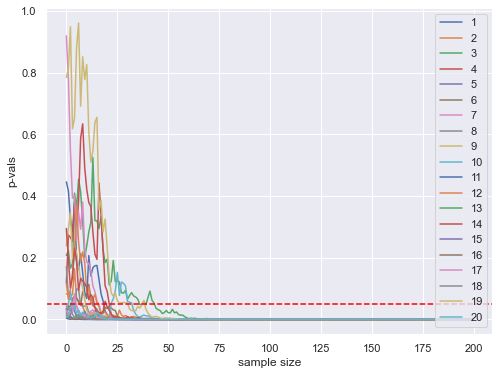

In [149]:
n_datapoints = 200
d_effect_size = 0.8
n_datapoints += 10

trials = {}

for trial in range(20):
    p_vals, x_vals, y_vals = [], [], []
    for idx in range(n_datapoints):
        x_vals.append(np.random.normal())
        y_vals.append(np.random.normal(loc=d_effect_size))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                p_vals.append(st.ttest_ind(x_vals[:idx], y_vals[:idx])[1])
            except TypeError:
                p_vals.append(np.nan)

    p_vals = p_vals[10:]
    trials[trial + 1] = p_vals
                  
fig, ax = plt.subplots(figsize=(8, 6))
pd.DataFrame(trials).plot(ax=ax)
ax.axhline(0.05, linestyle="--", color="red")
# print("The lowest p-value was observed at sample size ", p_vals.index(min(p_vals)) + 10)
# sig = [p_val for p_val in p_vals if p_val < 0.05]
# print("The p-value dropped below 0.05 for the first time at sample size:", p_vals.index(sig[0]) + 10 if sig else "NEVER")
# ax.set_title("P-values for multiple comparison as sample size increase, NO TRUE EFFECT")
ax.set_xlabel("sample size")
ax.set_ylabel("p-vals");

**Q4:** Looking at Figure 2.9, which statement is true?

1. Optional stopping does not impact the Type 1 error rate.
2. **Optional stopping inflates the Type 1 error rate. We can see this in the first five bars (p-values between 0.00 and 0.05), which are substantially higher than the horizontal line.**
3. Optional stopping inflates the Type 1 error rate. We can see this in the bars just above 0.05, which dip substantially below the uniform distribution that should be present if there is no true effect.


**Q5:** The script to simulate optional stopping provides written output. One summary gives you the Type 1 error rate for each individual look. One summary gives the Type 1 error rate when optional stopping is used. When running the script with the default values, which statement is true?

1. At each look, the Type 1 error rate is higher than the alpha level (0.05). When using optional stopping (and reporting only the lowest p-value), the Type 1 error rate is higher than 0.05.
2. At each look, the Type 1 error rate is approximately equal to the alpha level (0.05). When using optional stopping (and reporting only the lowest p-value), the alpha level also approximately equals the alpha level (0.05).
3. **At each look, the Type 1 error rate is approximately equal to the alpha level (0.05). When using optional stopping, the Type 1 error rate is higher than the alpha level (0.05).**


**Q6:** Change the number of looks in the simulation to 2 (change 'looks <- 5' to 'looks <- 2'), and leave all other settings the same. Run the simulation again. What is the Type 1 error rate using optional stopping with only 1 interim analysis, rounded to 2 digits? (Note that due to small number of simulations, the exact alpha level you get might differ a little bit from the answer options below).

1. 0.05
2. **0.08**
3. 0.12
4. 0.18


Type 1 error rates for look 1 to 2: [0.05038 0.0495 ]
Type 1 error rate when only the lowest p-value for all looks is reported: 0.08284


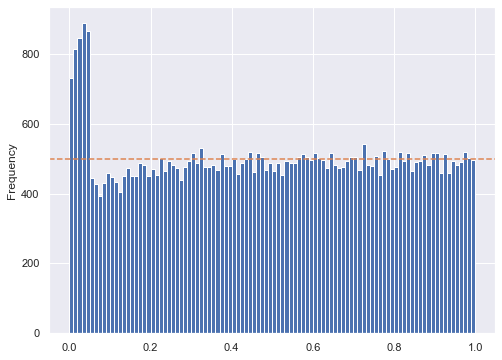

In [150]:
n_datapoints = 100
looks = 2
n_simulations = 50_000
alpha = 0.05

if looks > 0:
    look_at_n = np.ceil(np.arange(n_datapoints / looks, n_datapoints + 1, (n_datapoints - n_datapoints / looks) / (looks - 1)))

else:
    look_at_n = [n_datapoints]
    
look_at_n = [int(look) for look in look_at_n if look > 2]
looks = len(look_at_n)

p_vals = []
for idx_i in range(n_simulations):
    x = np.random.normal(size=n_datapoints)
    y = np.random.normal(size=n_datapoints)
    
    row = []
    for idx_j in range(looks):
        row.append(st.ttest_ind(x[:look_at_n[idx_j]], y[:look_at_n[idx_j]])[1])
    
    p_vals.append(row)
    print(f"Loop {idx_i} of {n_simulations}", end="\r")

p_vals = np.array(p_vals)
p_vals_filtered = []

for idx in range(n_simulations):
    if len(p_vals[idx, p_vals[idx] < alpha]) == 0:
        p_vals_filtered.append(p_vals[idx, looks - 1])
    else:
        p_vals_filtered.append(p_vals[idx, p_vals[idx] < alpha][0])
        
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(p_vals_filtered, name="p-vals").hist(bins=100, ax=ax)
ax.axhline(n_simulations/100, color="C1", linestyle="--")
ax.set_ylabel("Frequency")
print(f"Type 1 error rates for look 1 to {looks}: {(p_vals < alpha).sum(axis=0) / n_simulations}")
print(f"Type 1 error rate when only the lowest p-value for all looks is reported: {(np.array(p_vals_filtered) < alpha).sum() / n_simulations}")

**Q7**: As Wagenmakers (2007) notes: “a user of NHST could always obtain a significant result through optional stopping (i.e., analyzing the data as they accumulate and stopping the experiment whenever the p-value reaches some desired significance level)”. This is correct. It’s true that the p-value will always drop below the alpha level at some point in time. But, we need a rather large number of observations. We can calculate the maximum Type 1 error rate due to optional stopping for any maximum sample size. For example, what is the maximum Type 1 error rate when optional stopping is used when collecting 200 participants in each condition, and looking 200 times (or 198 times, given that you can’t perform a t-test on a sample size of 1 or 2 people)? Set the number of participants to 200, the number of looks to 200, the number of simulations to 10000 (this simulation will take even longer!), and the alpha to 0.05.

What is maximum Type 1 error rate when collecting 200 participants in each condition of an independent t-test, using optional stopping, rounded to 2 digits? (Note that the simulation will take a while, but still, due to the relatively small number of simulations, the exact alpha level you get might differ a little bit from the answer options below – choose the answer option closest to your result).

1. 0.05
2. 0.11
3. 0.20
4. **0.41**


Type 1 error rates for look 1 to 198: [0.0538 0.0547 0.0525 0.0513 0.0583 0.0543 0.0553 0.0524 0.0522 0.0515
 0.052  0.0505 0.0517 0.0497 0.0524 0.0503 0.0499 0.0529 0.0554 0.0545
 0.0565 0.0531 0.0538 0.0543 0.0542 0.0545 0.0527 0.0514 0.0504 0.0535
 0.0525 0.0511 0.0509 0.0497 0.0502 0.0499 0.0522 0.0514 0.0501 0.0511
 0.0507 0.0506 0.0523 0.0528 0.0522 0.0501 0.0515 0.0505 0.0496 0.0486
 0.0502 0.0504 0.0496 0.0494 0.0489 0.0482 0.048  0.0472 0.0469 0.0483
 0.0484 0.0488 0.0498 0.05   0.0488 0.0485 0.0504 0.0503 0.0491 0.0508
 0.0493 0.0494 0.0479 0.0488 0.0489 0.0475 0.0483 0.0482 0.0508 0.0496
 0.0498 0.0504 0.0507 0.0484 0.049  0.0479 0.048  0.0485 0.0489 0.0497
 0.0497 0.0498 0.0489 0.0512 0.0501 0.0492 0.0491 0.049  0.0493 0.0483
 0.0488 0.0474 0.0489 0.0483 0.048  0.0473 0.048  0.0488 0.0502 0.0493
 0.0501 0.0508 0.05   0.048  0.0485 0.0497 0.0501 0.0489 0.0495 0.0483
 0.0492 0.0473 0.0471 0.0481 0.0477 0.0488 0.0481 0.0478 0.0493 0.0493
 0.0509 0.0505 0.0509 0.0501 0.0508 0.0

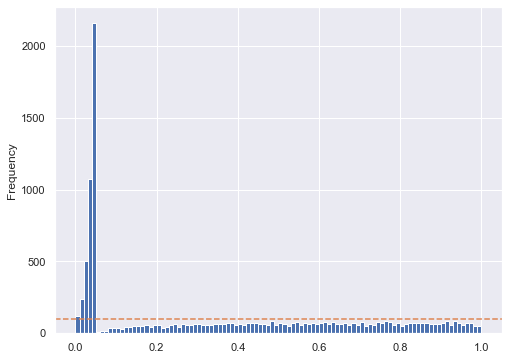

In [151]:
n_datapoints = 200
looks = 200
n_simulations = 10_000
alpha = 0.05

if looks > 0:
    look_at_n = np.ceil(np.arange(n_datapoints / looks, n_datapoints + 1, (n_datapoints - n_datapoints / looks) / (looks - 1)))

else:
    look_at_n = [n_datapoints]
    
look_at_n = [int(look) for look in look_at_n if look > 2]
looks = len(look_at_n)

p_vals = []
for idx_i in range(n_simulations):
    x = np.random.normal(size=n_datapoints)
    y = np.random.normal(size=n_datapoints)
    
    row = []
    for idx_j in range(looks):
        row.append(st.ttest_ind(x[:look_at_n[idx_j]], y[:look_at_n[idx_j]])[1])
    
    p_vals.append(row)
    print(f"Loop {idx_i} of {n_simulations}", end="\r")

p_vals = np.array(p_vals)
p_vals_filtered = []

for idx in range(n_simulations):
    if len(p_vals[idx, p_vals[idx] < alpha]) == 0:
        p_vals_filtered.append(p_vals[idx, looks - 1])
    else:
        p_vals_filtered.append(p_vals[idx, p_vals[idx] < alpha][0])
        
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(p_vals_filtered, name="p-vals").hist(bins=100, ax=ax)
ax.axhline(n_simulations/100, color="C1", linestyle="--")
ax.set_ylabel("Frequency")
print(f"Type 1 error rates for look 1 to {looks}: {(p_vals < alpha).sum(axis=0) / n_simulations}")
print(f"Type 1 error rate when only the lowest p-value for all looks is reported: {(np.array(p_vals_filtered) < alpha).sum() / n_simulations}")

**Q8**: At Wikipedia, look at the entry about the Pocock boundary: https://en.wikipedia.org/wiki/Pocock_boundary . There are ethical reasons to look at the data, while data is being collected. These are clear in medicine, but similar arguments can be made for other research areas (see Lakens, 2014). Researchers often want to look at the data multiple times. This is perfectly fine, as long as they design a study with a number of looks in advance, and control their Type 1 error rate.

The Pocock boundary provides a very easy way to control the type 1 error rate in sequential analyses. Sequential analysis is the formal way to do optional stopping. Researchers should use a slightly lower alpha level for each look, the make sure the overall alpha level (after all looks) is not larger than 5%.

Set the number of participants to 100, the number of looks to 5, and the number of simulations to 50000 (so back to the original script). In the Wikipedia article on the Pocock boundary, find the corrected alpha level for 5 looks at the data. Change the alpha level in the simulation to this value. Run the simulation. Which of the following statements is true?


1. The Type 1 error rate at each look is approximately 0.03, and the overall alpha level is approximately 0.05.
2. The Type 1 error rate at each look is approximately 0.03, and the overall alpha level is approximately 0.15.
3. **The Type 1 error rate at each look is approximately 0.016, and the overall alpha level is approximately 0.05.**
4. The Type 1 error rate at each look is approximately 0.016, and the overall alpha level is approximately 0.08.


Type 1 error rates for look 1 to 5: [0.01614 0.01576 0.01512 0.01566 0.0164 ]
Type 1 error rate when only the lowest p-value for all looks is reported: 0.04982


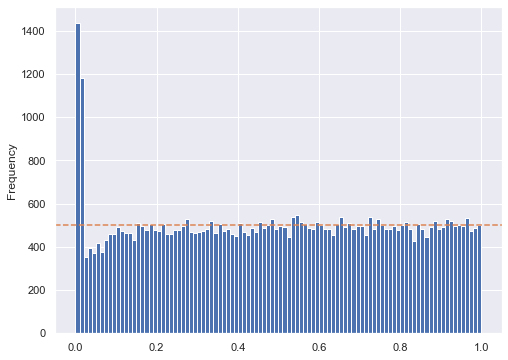

In [152]:
n_datapoints = 100
looks = 5
n_simulations = 50_000
alpha = 0.0158

if looks > 0:
    look_at_n = np.ceil(np.arange(n_datapoints / looks, n_datapoints + 1, (n_datapoints - n_datapoints / looks) / (looks - 1)))

else:
    look_at_n = [n_datapoints]
    
look_at_n = [int(look) for look in look_at_n if look > 2]
looks = len(look_at_n)

p_vals = []
for idx_i in range(n_simulations):
    x = np.random.normal(size=n_datapoints)
    y = np.random.normal(size=n_datapoints)
    
    row = []
    for idx_j in range(looks):
        row.append(st.ttest_ind(x[:look_at_n[idx_j]], y[:look_at_n[idx_j]])[1])
    
    p_vals.append(row)
    print(f"Loop {idx_i} of {n_simulations}", end="\r")

p_vals = np.array(p_vals)
p_vals_filtered = []

for idx in range(n_simulations):
    if len(p_vals[idx, p_vals[idx] < alpha]) == 0:
        p_vals_filtered.append(p_vals[idx, looks - 1])
    else:
        p_vals_filtered.append(p_vals[idx, p_vals[idx] < alpha][0])
        
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(p_vals_filtered, name="p-vals").hist(bins=100, ax=ax)
ax.axhline(n_simulations/100, color="C1", linestyle="--")
ax.set_ylabel("Frequency")
print(f"Type 1 error rates for look 1 to {looks}: {(p_vals < alpha).sum(axis=0) / n_simulations}")
print(f"Type 1 error rate when only the lowest p-value for all looks is reported: {(np.array(p_vals_filtered) < alpha).sum() / n_simulations}")

Q9: Look at the graph of the p-value distribution when using the Pocock boundary, and compare it to the graph you got when not using the Pocock boundary. You can flip back and forth between plots you have generated in RStudio using the blue arrows on the plots tab. Which statement is true?


1. Without Pocock’s boundary, small p-values (e.g., p = 0.01) are more likely than slightly higher p-values (p = 0.04). With Pocock’s boundary, small p-values (e.g., p = 0.01) are also more likely than slightly higher p-values (p = 0.04).
2. Without Pocock’s boundary, small p-values (e.g., p = 0.01) are more likely than slightly higher p-values (p = 0.04). With Pocock’s boundary, small p-values (e.g., p = 0.01) are less likely than slightly higher p-values (p = 0.04).
3. **Without Pocock’s boundary, small p-values (e.g., p = 0.01) are less likely than slightly higher p-values (p = 0.04). With Pocock’s boundary, small p-values (e.g., p = 0.01) are more likely than slightly higher p-values (p = 0.04).**
4. Without Pocock’s boundary, small p-values (e.g., p = 0.01) are less likely than slightly higher p-values (p = 0.04). With Pocock’s boundary, small p-values (e.g., p = 0.01) are also less likely than slightly higher p-values (p = 0.04).


1. What is the definition of the positive predictive value?
2. What is the definition of a false positive?
3. What is the definition of a false negative?
4. What is the definition of a true positive?
5. What is the definition of a true negative?
6. If you perform 200 studies, where there is a 50% probability H0 is true, you have 80% power, and use a 5% Type 1 error rate, what is the most likely outcome of a study?
7. How can you increase the positive predictive value in lines of research you decide to perform?
8. Why is it incorrect to think that “1 in 20 results in the published literature are Type 1 errors”?
9. What is the problem with optional stopping?
10. How do multiple tests inflate the Type 1 error rate, and what can be done to correct for multiple comparisons?
11. In a replication study, what determines the probability that you will observe a significant effect?
12. Which approach to statistical inferences is the Neyman-Pearson approach part of, and what is the main goal of the Neyman-Pearson approach?
13. How should error rates (alpha and beta) in a statistical test be determined?

